In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
sys.path.append("..")
from inference import GaussMarkovLagrange
from likelihoods import PointProcess
from mappings import AffineMapping
from transition import FixedPointSparseGP, SparseGP
from kernels import RBF
from linkfunctions import Exp
from models import PointProcessGPSDEmodel, GPSDE

In [2]:
print(torch.__version__) # double check that this is the version from requirements.txt

1.1.0


In [42]:
def vanderpol(x, a, tau):
    x1 = x[:,0]
    x2 = x[:,1]
    dx = a * (x1 - 1./3.*x1**3 - x2)
    dy = 1./a * x1
    return tau * np.array([dx, dy]).T

def simulate_sde(f, x0, tmax, dt, sigma=1.):
    x = np.array(x0)
    N = int(tmax / dt)
    for i in range(N - 1):
        x = np.append(x, x[i][None,:] + f(x[i][None,:]) * dt + np.sqrt(sigma * dt) * np.random.randn(1, max(x0.shape)),axis=0)
    return x


def simulate_spikes_from_SDE(xpath, dt, C, d):
    # simulate Poisson spiking conditioned on discretised path of SDE
    h = np.matmul(xpath,C) + d
    binSpike = np.random.poisson(np.exp(h) * dt)
    return binSpike, h


def binned_to_times(Ybin, tmax, dt):
    # convert binned simulated spike train to list of spike times for each neuron
    N = int(tmax / dt)
    yDim = Ybin.shape[0]
    tgrid = np.linspace(dt, tmax, N)
    Yspike = []
    for i in range(yDim):
        Yspike.append(tgrid[Ybin[i, :] > 0] + 1e-6 * np.random.randn(*np.shape(tgrid[Ybin[i, :] > 0])))

    return Yspike


def plotRaster(event_times_list, **kwargs):
    """ function to plot raster plot for a given trial"""
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax


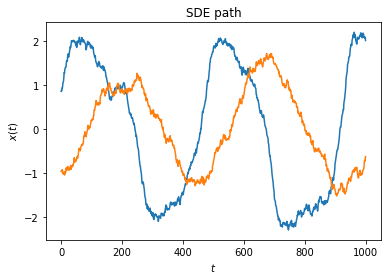

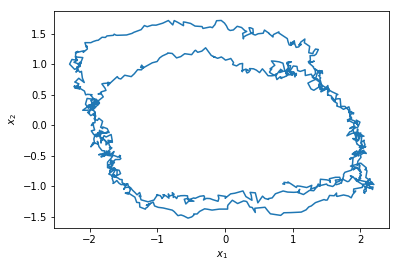

In [43]:
np.random.seed(17489)
# make a van der pols system with a stable limit cycle
x0 = np.random.randn(1, 2)
tau = 15
func = lambda x: vanderpol(x, 2.,tau)
tmax = 1
dt = 0.001


xpath = simulate_sde(func, x0, tmax, dt, 1.5) # 1ms binning 

plt.plot(xpath)
plt.title('SDE path')
plt.ylabel('$x(t)$')
plt.xlabel('$t$')
plt.show()

plt.plot(xpath[:,0],xpath[:,1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()


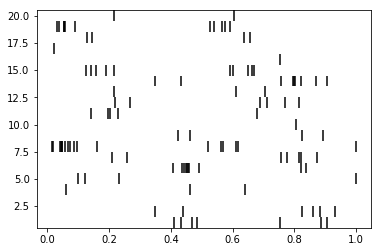

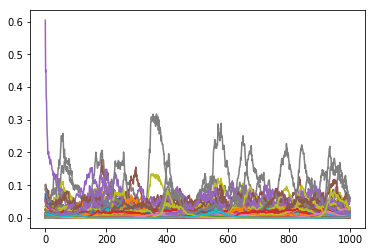

[2, 2, 1, 3, 2, 12, 3, 19, 5, 3, 5, 5, 2, 10, 15, 5, 3, 9, 4, 0]
110
[7, 6, 0, 3, 4, 10, 7, 18, 4, 1, 5, 6, 3, 9, 10, 1, 1, 4, 11, 2]
112
[4, 2, 1, 1, 4, 9, 3, 9, 9, 2, 4, 10, 2, 6, 11, 2, 4, 5, 3, 6]
97
[2, 3, 2, 3, 3, 11, 0, 23, 8, 2, 8, 4, 1, 9, 12, 2, 6, 6, 12, 6]
123
[9, 5, 0, 1, 2, 18, 2, 4, 12, 2, 5, 3, 2, 12, 16, 3, 1, 6, 7, 3]
113
[6, 3, 1, 2, 5, 14, 2, 32, 6, 1, 7, 6, 2, 12, 23, 0, 3, 11, 13, 5]
154
[6, 1, 1, 1, 4, 8, 1, 6, 11, 0, 4, 3, 0, 10, 12, 2, 3, 10, 2, 2]
87
[5, 2, 0, 1, 4, 11, 3, 15, 7, 1, 8, 10, 0, 4, 18, 2, 4, 8, 4, 2]
109
[5, 2, 0, 1, 3, 8, 1, 17, 8, 5, 6, 5, 2, 9, 15, 3, 4, 6, 9, 1]
110
[4, 4, 2, 0, 8, 19, 3, 13, 11, 3, 3, 4, 2, 9, 10, 2, 2, 7, 8, 2]
116
[5, 1, 2, 0, 9, 8, 1, 16, 5, 0, 8, 2, 2, 5, 23, 1, 3, 8, 15, 6]
120
[2, 3, 0, 3, 4, 15, 0, 8, 5, 1, 10, 4, 2, 13, 15, 0, 2, 4, 4, 3]
98
[3, 7, 0, 0, 3, 19, 1, 14, 6, 2, 8, 3, 0, 5, 15, 2, 4, 8, 12, 3]
115
[3, 6, 3, 1, 5, 15, 3, 10, 3, 1, 9, 7, 1, 6, 18, 3, 0, 4, 2, 1]
101
[4, 4, 0, 1, 4, 8, 3, 4, 8, 0, 5, 7, 0, 7

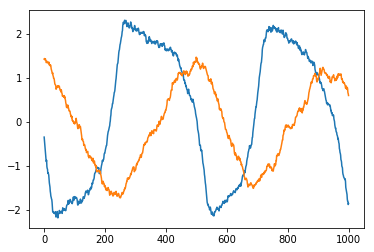

In [45]:
np.random.seed(101)

yDim = 20 # number of neurons
xDim = 2
nTrials = 20 # number of trials
tmax = 1
trLen = tmax * np.ones(nTrials) # trial length
C = 2.*np.random.rand(xDim,yDim) * np.random.choice([-1,1],size=(xDim,yDim))
d = 0.1*np.random.randn(1,yDim)
xpath = []
Y = []
logRate = []

for n in range(nTrials):
    if n < 10:
        x0 = np.sqrt(2)*np.random.randn(1,2)
    else:
        x0 = np.array([0, 0])[None,:]

    xpath.append(simulate_sde(func, x0, trLen[n], 0.001, 1.)) # 1ms binning 
    Yn,logRaten = simulate_spikes_from_SDE(xpath[n], 0.001, C, d)
    Y.append(Yn)
    logRate.append(logRaten)

Yspike= [binned_to_times(Y[n].T,trLen[n],0.001) for n in range(nTrials)]


plotRaster(Yspike[1])
plt.show()

# look at firing rates and spike counts to make sure there aren't a crazy number of spikes due to exponential

for r in range(nTrials):
    plt.plot(np.exp(logRate[r])*0.001)
plt.show()

for r in range(nTrials):
    totSpikes = [len(Yspike[r][i]) for i in range(yDim)]
    print(totSpikes)
    print(sum(totSpikes))


plt.plot(xpath[1])
plt.show()

In [47]:
dtgrid = 0.004 # discretisation for solving ODEs
xDim = 2 # two latents

# pick model components:
link = Exp() # exponential link function
like = PointProcess(Yspike, link, trLen, dtstep=dtgrid, nLeg=100) # point process likelihood
outputMapping = AffineMapping(torch.tensor(C), torch.tensor(d)) # affine output mapping
kern = RBF(xDim) # RBF kernel

# generater inducing point locations on a 2D grid
xmin, xmax = -2., 2.
Zs1, Zs2 = torch.meshgrid([torch.linspace(xmin,xmax,5), torch.linspace(xmin,xmax,5)])
numZ = 25
Zs = torch.cat((Zs1.reshape(-1,1),Zs2.reshape(-1,1)),dim=1)

# generater inducing point locations on a 2D grid
xmin, xmax = -2, 2
Zs1, Zs2 = torch.meshgrid([torch.linspace(xmin,xmax,5), torch.linspace(xmin,xmax,5)])
numZ = 25
Zs = torch.cat((Zs1.reshape(-1,1),Zs2.reshape(-1,1)),dim=1)

transfunc = SparseGP(kern, Zs) # choose sparse GP as a transition function
transfunc.q_mu.data = torch.randn(transfunc.q_mu.size()).type(torch.float64) # random initialisation for inducing point posterior mean

# uncomment to instead condition on fixed points
#Zs_fx = torch.tensor([0., 0.]).view(-1,xDim)
# transition function conditioned on fixed point
#transfunc = SparseGP(kern, Zs, Zs_fx) 


# build point procces generative model for continuous time spike-time observations
model = PointProcessGPSDEmodel(xDim, transfunc, outputMapping, like, nLeg=100)

# assemble inference algorithm
inference = GaussMarkovLagrange(xDim, trLen, learningRate=1, dtstep=dtgrid)

# create GPSDE model object 
myGPSDE = GPSDE(model, inference)

# fix inducing points on chosen grid
myGPSDE.model.transfunc.Zs.requires_grad = False


In [48]:
# run EM (increase number of iterations for better results)
myGPSDE.variationalEM(niter=30,eStepIter=10, mStepIter=10)

-------------------------------------------------------
iter   objective    log-like      kl-div     f-prior
-------------------------------------------------------
   0   -2661.878    3600.040     906.545     -31.616
   1   -3322.892    3789.509     429.935     -36.682
   2   -3625.644    4013.722     348.287     -39.790
   3   -3728.204    4118.302     346.743     -43.355
   4   -3777.032    4162.010     338.975     -46.003
   5   -3807.186    4187.826     329.774     -50.866
   6   -3825.016    4199.628     321.590     -53.021
   7   -3836.663    4207.214     316.577     -53.974
   8   -3844.025    4212.376     313.012     -55.339
   9   -3849.704    4215.732     309.488     -56.540
  10   -3853.904    4218.119     306.826     -57.388
  11   -3857.595    4219.611     303.742     -58.273
  12   -3860.688    4220.925     301.899     -58.338
  13   -3863.422    4221.953     299.544     -58.987
  14   -3865.500    4222.970     298.274     -59.196


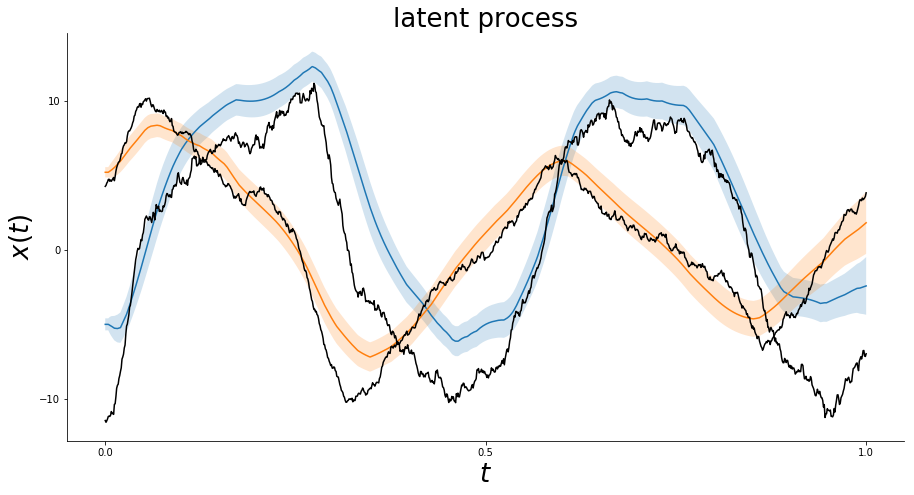

In [58]:
# evaluate trial
idx = 2
testTimes = torch.linspace(0,trLen[idx],int(trLen[idx]/0.001))

m, S = myGPSDE.inference.predict_marginals(idx, testTimes)
mr, Sr, Corth = myGPSDE.model.outputMapping.orthogonaliseLatents(m,S)


# plot the latent path and data in orthogonalised subspace
f, ax = plt.subplots()
f.set_figheight(7.5)
f.set_figwidth(15)
for i in range(xDim):
#     ax.plot(testTimes.numpy(),xpath[idx],color='black',linewidth=0.5,label='x(t)')
    ax.plot(testTimes.numpy(),mr[:,0,i].detach().squeeze().numpy(), label='$m_x(t)$')
    ax.fill_between(testTimes.numpy(), mr[:,0,i].detach().numpy()+np.sqrt(Sr[:,i,i].detach().numpy()), 
                mr[:,0,i].detach().squeeze().numpy()-np.sqrt(Sr[:,i,i].detach().numpy()), alpha=0.2)

    
Latents = Corth.detach().numpy().T @ (np.stack(logRate[idx] - d).T) # data projected into same subspace as inferred latents
plt.plot(np.linspace(0,trLen[idx],int(trLen[idx]/0.001)),Latents[0,:],color='black')
plt.plot(np.linspace(0,trLen[idx],int(trLen[idx]/0.001)),Latents[1,:],color='black')

# plot where observatioins lie
ax.locator_params(nbins=4)
ax.set_ylabel('$x(t)$',fontsize=26)
ax.set_xlabel('$t$',fontsize=26)
ax.set_title('latent process',fontsize=26)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [59]:
# visualise learned transition function and true transition function
ngrid = 20
xmin = -2.5
xmax = 2.5
x = torch.linspace(xmin,xmax,ngrid)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)
out_est = myGPSDE.model.transfunc.predict(xygrid.unsqueeze(0))
out_true = func(np.concatenate((yv.numpy().reshape(-1, 1),xv.numpy().reshape(-1, 1)),axis=1))


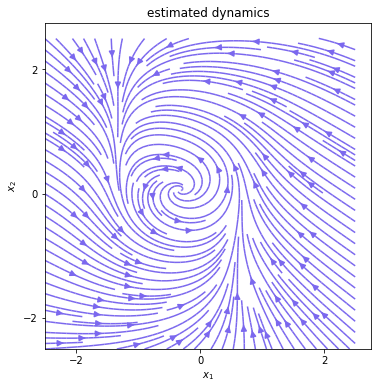

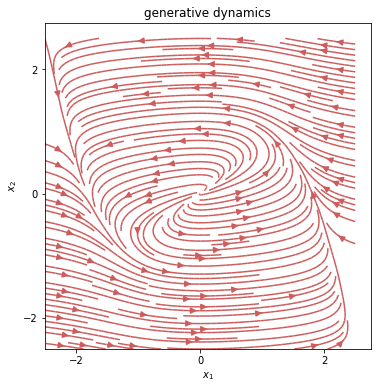

In [60]:

# visualise dynamics
sz = 6
plt.figure(figsize=(sz,sz))

plt.streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')

        
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('estimated dynamics')
plt.axis('square')
plt.locator_params(nbins=3)
plt.show()

plt.figure(figsize=(sz,sz))
plt.streamplot(x.numpy(), y.numpy(), out_true[:,0].reshape(ngrid,ngrid), out_true[:,1].reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='indianred')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('generative dynamics')
plt.axis('square')
plt.locator_params(nbins=3)

plt.show()